In [1]:
from IPython.display import Image

- https://github.com/volcengine/verl.git
    - https://verl.readthedocs.io/en/latest/start/quickstart.html
- 默认用 fsdp 的分布式
- RL dataflow
    - trajectory sample
    - loss function

## basics

### single controller vs. multi controller

- single-controller 实现RL dataflow
- multi-controller 实现各个 LLM component
    - 训练：fsdp，megtron-lm，deepspeed
    - 推理：vllm、sglang

In [4]:
Image(url='./imgs/controlers.png', width=600)

In [15]:
import multiprocessing
import os
def process_data(data):
    # 处理数据的代码（例如，每个计算单元处理不同的数值）
    pid = os.getpid()
    print(f'{pid}: {data}')
    return data ** 2

def main():
    # 假设我们有多个数据项，每个进程处理一个数据项
    data = [1, 2, 3, 4, 5]
    # SPMD
    # 使用multiprocessing Pool来并行处理
    with multiprocessing.Pool(processes=4) as pool:
        results = pool.map(process_data, data)
    
    print(results)

main()

236979: 3236978: 2236980: 4236977: 1



236978: 5
[1, 4, 9, 16, 25]


## conpoments

In [17]:
Image(url='./imgs/verl_components.png', width=500)

- trainer, rollout, data,
    - `When rollout.temperature=0, data.n_samples must be 1.`
    - rollout.name
        - hf: tgi
        - vllm
- role
    - `'actor', 'rollout', 'ref', 'actor_rollout', 'actor_rollout_ref'`

### Single controler vs. Multi controller

```
# RLHF Single Process Controller

# initialize worker groups
actor_wg = ...
critic_wg = ...
ref_wg = ...
reward_wg = ...

# ppo actor/rollout
for prompt_batch in dataloader:
    batch = actor_wg.generate_sequences(prompt_batch)
    values = critic_wg.compute_values(batch)
    ref_log_prob = ref_wg.compute_log_prob(batch)
    score = reward_wg.compute_reward(batch)
    returns, advantage = compute_advantage(score, ref_log_prob, values)
    actor_wg.update(batch, advantage)
    critic_wg.update(batch, returns)

```

In [18]:
Image(url='./imgs/generalized_hybrid_engine.png', width=500)

### TP(DP) with Ray

- DP = 2, TP = 2
    - 首先在 data 维度做拆分；batch 0，batch 1
    - 在 dp 内部，将相同的数据发送给所有的 rank
    - workergroup 做 data dispatch 和 data aggregation
        - 如下图的 dispatch_fn 与 collect_fn

In [5]:
Image(url='./imgs/dp_tp.png', width=500)

In [6]:
Image(url='./imgs/dispatch_collect.png', width=500)

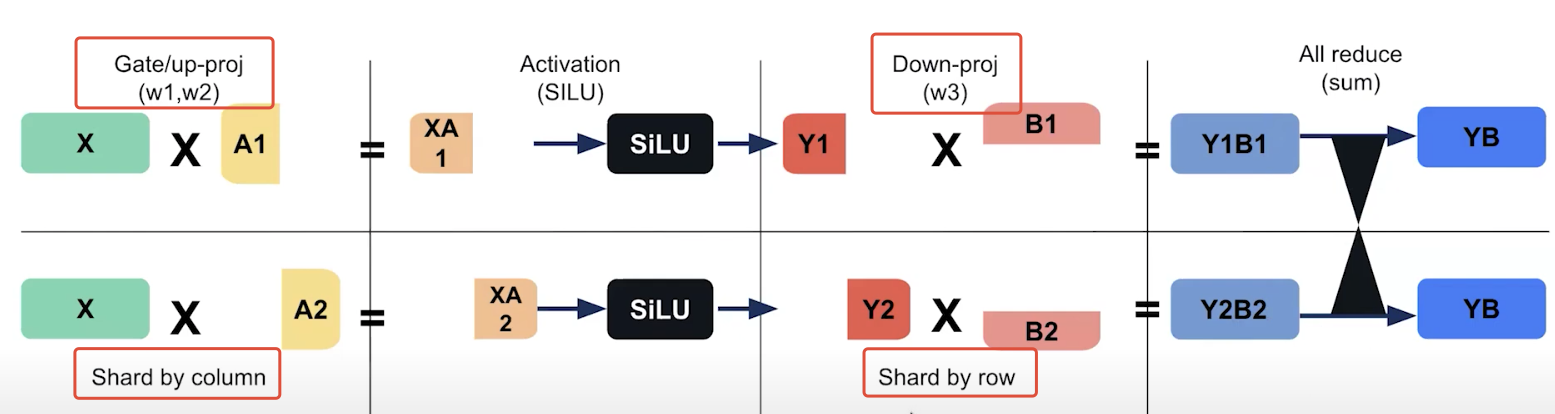

In [2]:
Image('./imgs/tp_ffn.png', width=500)

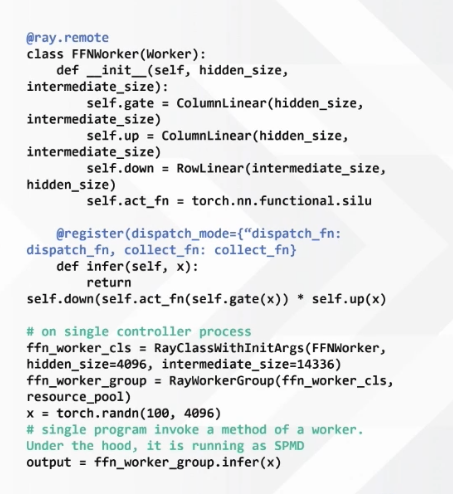

In [3]:
Image('./imgs/ray_tp.png', width=500)

## quickstart

- ppo
    - actor_rollout_ref.model.path=Qwen/Qwen2.5-0.5B-Instruct \
    - critic.model.path=Qwen/Qwen2.5-0.5B-Instruct \
    - pre-defined rule-based reward model.
        - https://github.com/volcengine/verl/blob/v0.1/verl/utils/reward_score/gsm8k.py

## main_generation

```
python3 -m verl.trainer.main_generation \
        trainer.nnodes=1 \
        trainer.n_gpus_per_node=2 \
        data.path=$HOME/data/gsm8k/test.parquet \
        data.output_path=$HOME/data/gsm8k/gsm_q_0.5.parquet \
        data.n_samples=1 \
        data.batch_size=1 \
        model.path=Qwen/Qwen2.5-0.5B-Instruct \
        rollout.temperature=0.6 \
        rollout.response_length=32768 \
        rollout.top_k=-1 \
        rollout.top_p=0.95 \
        rollout.gpu_memory_utilization=0.9 \
        rollout.tensor_model_parallel_size=1
```